## Image segmentation with CamVid

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [3]:
print(URLs.CAMVID)

https://s3.amazonaws.com/fast-ai-imagelocal/camvid


In [4]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/home/zach/.fastai/data/camvid/images'),
 PosixPath('/home/zach/.fastai/data/camvid/valid.txt'),
 PosixPath('/home/zach/.fastai/data/camvid/labels'),
 PosixPath('/home/zach/.fastai/data/camvid/codes.txt'),
 PosixPath('/home/zach/.fastai/data/camvid/saplingModel.py')]

In [5]:
path_lbl = path/'labels'
path_img = path/'images'

## Subset classes

In [6]:
# path = Path('./data/camvid-small')

# def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name

# codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
#     'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

# src = (SegmentationItemList.from_folder(path)
#        .split_by_folder(valid='val')
#        .label_from_func(get_y_fn, classes=codes))

# bs=8
# data = (src.transform(get_transforms(), tfm_y=True)
#         .databunch(bs=bs)
#         .normalize(imagenet_stats))

## Data

In [7]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/home/zach/.fastai/data/camvid/images/img19_2.png'),
 PosixPath('/home/zach/.fastai/data/camvid/images/img19_1.png'),
 PosixPath('/home/zach/.fastai/data/camvid/images/img3_0.png')]

In [8]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/home/zach/.fastai/data/camvid/labels/img3_4_P.png'),
 PosixPath('/home/zach/.fastai/data/camvid/labels/img10_1_P.png'),
 PosixPath('/home/zach/.fastai/data/camvid/labels/img7_2_P.png')]

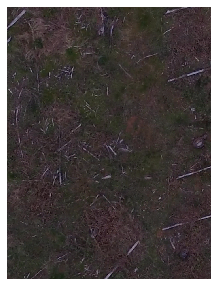

In [9]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [10]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

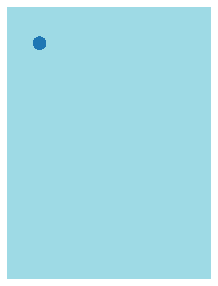

In [11]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [12]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([960, 720]), tensor([[[3, 3, 3,  ..., 3, 3, 3],
          [3, 3, 3,  ..., 3, 3, 3],
          [3, 3, 3,  ..., 3, 3, 3],
          ...,
          [3, 3, 3,  ..., 3, 3, 3],
          [3, 3, 3,  ..., 3, 3, 3],
          [3, 3, 3,  ..., 3, 3, 3]]]))

In [13]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['sapling', 'ground', 'Void', 'ground'], dtype='<U7')

## Datasets

In [14]:
size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=4, have 7768MB of GPU RAM free


In [15]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [16]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

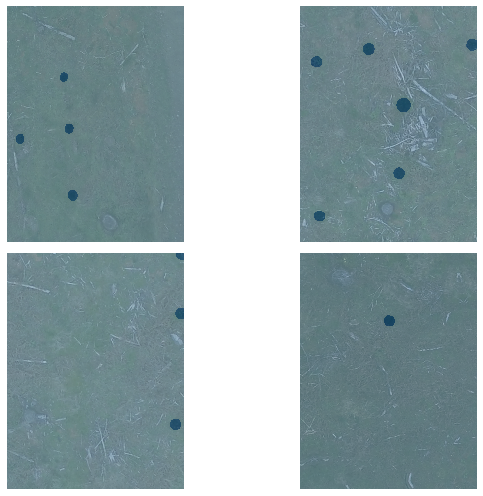

In [17]:
data.show_batch(2, figsize=(10,7))

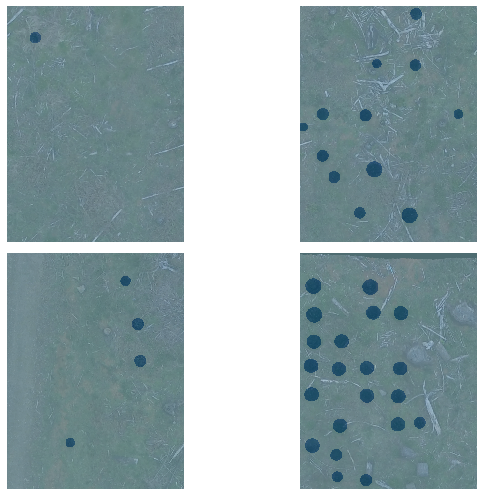

In [18]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [19]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [20]:
metrics=acc_camvid
# metrics=accuracy

In [21]:
wd=1e-2

In [22]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


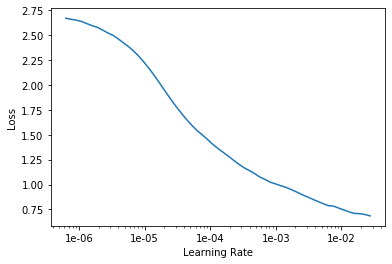

In [23]:
lr_find(learn)
learn.recorder.plot()

In [24]:
lr=3e-3

In [25]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.763307,0.589980,0.976126,00:06
1,0.433150,0.199446,0.976134,00:05
2,0.335851,0.270241,0.976174,00:05
3,0.264607,0.121532,0.976174,00:05
4,0.212943,0.151289,0.976174,00:05
5,0.177030,0.106663,0.976174,00:05
6,0.150204,0.104387,0.976174,00:05
7,0.129979,0.102587,0.976174,00:05
8,0.115104,0.097913,0.976174,00:05
9,0.102583,0.072485,0.976845,00:05


In [26]:
learn.save('stage-1')

In [27]:
learn.load('stage-1');

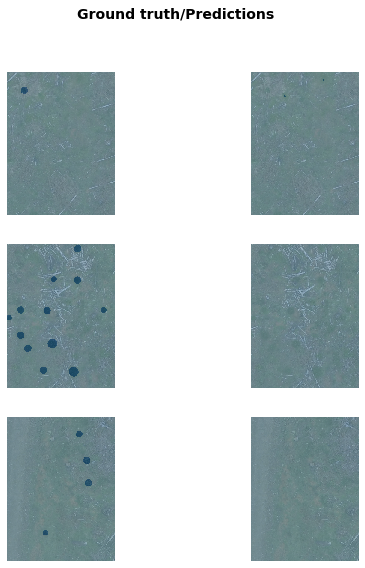

In [28]:
learn.show_results(rows=3, figsize=(8,9))

In [29]:
learn.unfreeze()

In [30]:
lrs = slice(lr/400,lr/4)

In [31]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.028933,0.067353,0.979299,00:05
1,0.027440,0.072949,0.979197,00:05
2,0.027816,0.059561,0.981414,00:05
3,0.026234,0.056472,0.982153,00:05
4,0.025023,0.070633,0.981465,00:05
5,0.024701,0.063420,0.981488,00:05
6,0.022903,0.055370,0.982289,00:05
7,0.022475,0.180596,0.976523,00:05
8,0.022372,0.110675,0.978980,00:05
9,0.022234,0.076662,0.980674,00:05


In [32]:
learn.save('stage-2');

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [33]:
learn.destroy()

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

this Learner object self-destroyed - it still exists, but no longer usable
using bs=1, have 7181MB of GPU RAM free


In [34]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [35]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [36]:
learn.load('stage-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


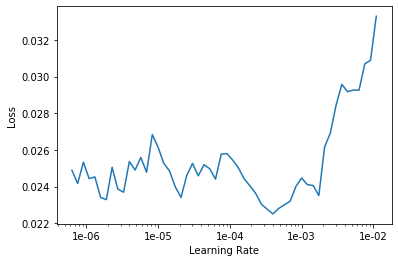

In [37]:
lr_find(learn)
learn.recorder.plot()

In [38]:
lr=1e-3

In [39]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.024003,0.058947,0.980190,00:18
1,0.022165,0.060742,0.981646,00:18
2,0.022222,0.055099,0.982139,00:18
3,0.021531,0.052961,0.982620,00:18
4,0.026804,0.075921,0.976116,00:18
5,0.027620,0.057686,0.981844,00:18
6,0.028314,0.061089,0.979239,00:18
7,0.025177,0.076568,0.982542,00:18
8,0.023354,0.052669,0.983662,00:18
9,0.020322,0.057053,0.981883,00:18


In [40]:
learn.save('stage-1-big')

In [41]:
learn.load('stage-1-big');

In [42]:
learn.unfreeze()

In [43]:
lrs = slice(1e-6,lr/10)

In [44]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.013987,0.049029,0.983694,00:19
1,0.013471,0.049421,0.983448,00:18
2,0.012838,0.052930,0.983601,00:18
3,0.014353,0.048930,0.983388,00:18
4,0.013380,0.051884,0.983541,00:18
5,0.012296,0.056987,0.983511,00:19
6,0.011412,0.064085,0.983197,00:18
7,0.011099,0.067618,0.982724,00:19
8,0.010485,0.057279,0.983332,00:19
9,0.009948,0.059019,0.983286,00:19


In [45]:
learn.save('stage-2-big')

In [46]:
learn.load('stage-2-big');

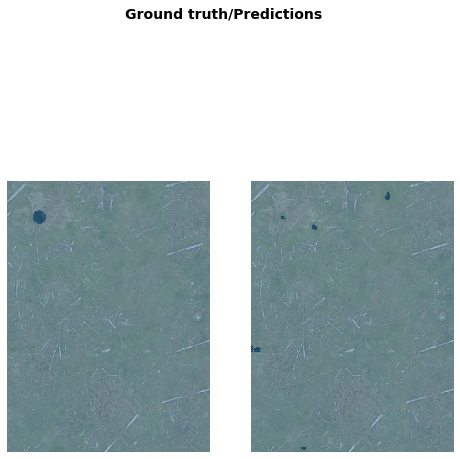

In [47]:
learn.show_results(rows=3, figsize=(8,9))

In [48]:
learn.export()

## fin

In [49]:
print(learn.path)

/home/zach/.fastai/data/camvid/images
